In [52]:
from torch import nn
from torch.nn import functional
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import gym
from collections import deque
import random
import numpy as np

In [53]:
import pickle

def save_rewards_data(rewards_data, filename='rewards_data.pkl'):
    """Save the rewards data to a pickle file."""
    with open(filename, 'wb') as file:
        pickle.dump(rewards_data, file)
    print(f'Rewards data saved to {filename}')


def load_rewards_data(filename='rewards_data.pkl'):
    """Load the rewards data from a pickle file."""
    try:
        with open(filename, 'rb') as file:
            rewards_data = pickle.load(file)
        print(f'Rewards data loaded from {filename}')
        return rewards_data
    except FileNotFoundError:
        print(f'Error: The file {filename} does not exist. Please check the file path and try again.')
        return None
    except Exception as e:
        print(f'An error occurred while loading the data: {e}')
        return None

In [54]:
import matplotlib.pyplot as plt

def plot_rewards(rewards_data, algorithm_name="Q learning"):
    """Plot the average performance and IQR of the policy."""
    plt.figure(figsize=(14, 7))

    for epsilon, alphas in rewards_data.items():
        for alpha, data in alphas.items():
            # Calculate average and IQR across runs for each episode
            data = np.array(data)  # Convert to numpy array for easier slicing
            avg_rewards = np.mean(data, axis=0)
            lower_quartile = np.percentile(data, 25, axis=0)
            upper_quartile = np.percentile(data, 75, axis=0)

            episodes = np.arange(len(avg_rewards)) + 1
            plt.plot(episodes, avg_rewards, label=f'ε={epsilon}, α={alpha}')
            plt.fill_between(episodes, lower_quartile, upper_quartile, alpha=0.25)

    plt.title(f'Average Performance and IQR by Epsilon and Alpha ({algorithm_name})')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.show()

In [55]:
class RBFDiscritizer:
    def __init__(self, num_rbf_per_state, state_bounds, num_states):
        self.num_rbf_per_state = num_rbf_per_state
        self.state_bounds = state_bounds
        self.num_states = num_states
        self.num_rbf = num_rbf_per_state * np.ones(self.num_states).astype(int)
        self.num_ind = np.prod(self.num_rbf)
        self.width = 1. / (self.num_rbf - 1.)
        self.rbf_sigma = self.width[0] / 2.
        self.rbf_den = 2 * self.rbf_sigma ** 2
        self.centres = self.build_centers()

    def build_centers(self):
        # Generate a meshgrid for the centers based on the number of RBFs per dimension
        ranges = [np.linspace(0, 1, num) for num in self.num_rbf]
        mesh = np.meshgrid(*ranges, indexing='ij')
        # Flatten the meshgrid and stack it to get the center coordinates
        center_coords = np.stack([axis.flatten() for axis in mesh], axis=-1)
        return center_coords

    def normalize_state(self, state):
        normalized = np.zeros(len(state))
        for i, (lower, upper) in enumerate(self.state_bounds):
            normalized[i] = (state[i] - lower) / (upper - lower)
        return normalized

    def encode(self, state):
        normalized_state = self.normalize_state(state)
        _phi = np.zeros(self.num_ind)
        for _k in range(self.num_ind):
            _phi[_k] = np.exp(-np.linalg.norm(normalized_state - self.centres[_k, :]) ** 2 / self.rbf_den)
        return _phi

In [56]:
class Model(nn.Module):
    def __init__(self, input_features, output_values):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features=input_features, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=output_values)

    def forward(self, x):
        x = functional.selu(self.fc1(x))
        x = functional.selu(self.fc2(x))
        x = self.fc3(x)
        return x

In [57]:
class DDQN:
    def __init__(self, env, discretizer, use_cuda=True, learning_rate=1e-5, gamma=0.7, memory_len=10000, start_epsilon=1):
        self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
        self.env = env
        self.discretizer = discretizer
        self.learning_rate = learning_rate
        self.gamma = gamma

        self.epsilon = start_epsilon
        self.min_epsilon = 0.1
        self.epsilon_decay = 0.9 / 2.5e3
        self.memory_len = memory_len
        self.memory = deque(maxlen=self.memory_len)
        self.criterion = nn.MSELoss()

        input_features = discretizer.num_ind
        output_values = env.action_space.n
        self.policy_net = Model(input_features, output_values).to(self.device)
        self.target_net = Model(input_features, output_values).to(self.device)

        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

    def get_states_tensor(self, sample, states_idx):
        sample_len = len(sample)
        states_tensor = torch.empty((sample_len, self.discretizer.num_ind), dtype=torch.float32, requires_grad=False)

        for i, state in enumerate(sample):
            num_array = state[states_idx]
            states_tensor[i, :] = torch.from_numpy(num_array)

        return states_tensor

    def normalize_state(self, state):
        state[0] /= 2.5
        state[1] /= 2.5
        state[2] /= 0.3
        state[3] /= 0.3

    def state_reward(self, state, env_reward):
        return env_reward - (abs(state[0]) + abs(state[2])) / 2.5

    def get_action(self, state, e=None):
        if e is None:
            e = self.epsilon
        if random.random() < e:
            return random.randrange(0, self.env.action_space.n)
        else:
            encoded_state = self.discretizer.encode(state)
            encoded_state = torch.tensor(encoded_state, dtype=torch.float32, device=self.device)
            return self.policy_net(encoded_state).argmax().item()

    def fit(self, model, inputs, labels):
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)
        train_ds = TensorDataset(inputs, labels)
        train_dl = DataLoader(train_ds, batch_size=5)

        optimizer = torch.optim.Adam(params=model.parameters(), lr=self.learning_rate)
        model.train()
        total_loss = 0.0

        for x, y in train_dl:
            out = model(x)
            loss = self.criterion(out, y)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        return total_loss / len(train_dl)

    def optimize_model(self, train_batch_size=100):
        if len(self.memory) < train_batch_size:
            return
        train_sample = random.sample(self.memory, train_batch_size)

        state = self.get_states_tensor(train_sample, 0).to(self.device)
        next_state = self.get_states_tensor(train_sample, 3).to(self.device)

        q_estimates = self.policy_net(state).detach()
        next_state_q_estimates = self.target_net(next_state).detach()
        next_actions = self.policy_net(next_state).argmax(dim=1)

        for i in range(len(train_sample)):
            next_action = next_actions[i].item()
            q_estimates[i][train_sample[i][1]] = (self.state_reward(next_state[i], train_sample[i][2]) +
                                                  self.gamma * next_state_q_estimates[i][next_action].item())

        self.fit(self.policy_net, state, q_estimates)

    def train_one_episode(self):
        current_state = self.env.reset()
        self.normalize_state(current_state)
        done = False
        score = 0
        reward = 0
        while not done:
            action = self.get_action(current_state, self.epsilon)
            next_state, env_reward, done, _ = self.env.step(action)
            self.normalize_state(next_state)
            encoded_current_state = self.discretizer.encode(current_state)
            encoded_next_state = self.discretizer.encode(next_state)
            self.memory.append((encoded_current_state, action, env_reward, encoded_next_state))
            current_state = next_state
            score += env_reward
            reward += self.state_reward(next_state, env_reward)

            self.optimize_model(100)

            self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)

        return score, reward

    def test(self):
        state = self.env.reset()
        self.normalize_state(state)
        done = False
        score = 0
        reward = 0
        while not done:
            action = self.get_action(state, 0)  # Using 0 to bypass random action selection
            state, env_reward, done, _ = self.env.step(action)
            self.normalize_state(state)
            score += env_reward
            reward += self.state_reward(state, env_reward)

        return score, reward

In [58]:
num_states = 4
num_rbf_per_state=4
state_bounds = [(-2.4, 2.4), (-10.0, 10.0), (-0.42, 0.42), (-10.0, 10.0)]

discretizer = RBFDiscritizer(num_rbf_per_state=num_rbf_per_state, state_bounds=state_bounds, num_states=num_states)

env = gym.make('CartPole-v1')

In [59]:
discretizer.centres

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333],
       [0.        , 0.        , 0.        , 0.66666667],
       ...,
       [1.        , 1.        , 1.        , 0.33333333],
       [1.        , 1.        , 1.        , 0.66666667],
       [1.        , 1.        , 1.        , 1.        ]])

In [60]:
def main(used_alpha, used_epsilon, env, discretizer, target_update_delay, test_delay, memory_len=10000, num_runs=1, num_episode=1000, save_file=""):


    # Initialize storage for reward data
    rewards_data = {epsilon: {alpha: [] for alpha in used_alpha} for epsilon in used_epsilon}

    for epsilon in used_epsilon:
        for alpha in used_alpha:
            print(f"Training with epsilon: {epsilon}, alpha: {alpha}")
            run_rewards = []  # Collect rewards for each run for the current config

            for run in range(num_runs):
                
                # avoid decay
                current_epsilon = epsilon

                print(f"Run {run + 1}/{num_runs}")
                
                # renew the wrapper class
                ddqn = DDQN(
                    env=env, 
                    discretizer=discretizer, 
                    use_cuda=True, 
                    learning_rate=alpha, 
                    gamma=0.99,
                    memory_len=memory_len, 
                    start_epsilon=current_epsilon
                )

                best_test_reward = 0

                episode_rewards = []  # Collect rewards for each episode in the current run
                for i in range(num_episode):
                    score, reward = ddqn.train_one_episode()

                    print(f'Episode {i + 1}: score: {score} - reward: {reward}')

                    if i % target_update_delay == 0:
                        ddqn.target_net.load_state_dict(ddqn.policy_net.state_dict())
                        ddqn.target_net.eval()

                    if (i + 1) % test_delay == 0:
                        test_score, test_reward = ddqn.test()
                        print(f'Test Episode {i + 1}: test score: {test_score} - test reward: {test_reward}')
                        if test_reward > best_test_reward:
                            print('New best test reward. Saving model')
                            best_test_reward = test_reward
                            # torch.save(ddqn.policy_net.state_dict(), f'policy_net_{run}.pth')

                    # Add the rewards
                    episode_rewards.append(score)

                if num_episode % test_delay != 0:
                    test_score, test_reward = ddqn.test()
                    print(f'Test Episode {num_episode}: test score: {test_score} - test reward: {test_reward}')
                    if test_reward > best_test_reward:
                        print('New best test reward. Saving model')
                        best_test_reward = test_reward
                        # torch.save(ddqn.policy_net.state_dict(), f'policy_net_{run}.pth')

                # save the run rewards
                run_rewards.append(episode_rewards)

                print(f'best test reward: {best_test_reward}')

            # Store the rewards for the current epsilon and alpha configuration
            rewards_data[epsilon][alpha] = run_rewards

    if not(save_file == ""):
        save_rewards_data(rewards_data, save_file)

    return rewards_data

In [61]:
# alpha = 1e-4, decaying epsilon = 1, rbf = 4 (save in example_data.pkl)
rewards_data = main(
    used_alpha=[1e-4], 
    used_epsilon=[1],  # decaying epsilon
    env=env, 
    discretizer=discretizer,
    target_update_delay=5, 
    test_delay=10,
    memory_len=10000, 
    num_runs=3, 
    num_episode=500, 
    save_file="example_data.pkl"
)

Training with epsilon: 1, alpha: 0.0001
Run 1/3
Episode 1: score: 23.0 - reward: 19.55175599753857
Episode 2: score: 35.0 - reward: 30.817770332098007
Episode 3: score: 14.0 - reward: 12.272358597815037


/Users/alanyang/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 4: score: 74.0 - reward: 62.98235526233911
Episode 5: score: 33.0 - reward: 29.936179313436153
Episode 6: score: 12.0 - reward: 10.638336530327797
Episode 7: score: 19.0 - reward: 16.661753793060782
Episode 8: score: 20.0 - reward: 18.03729310929775
Episode 9: score: 17.0 - reward: 14.592363733053208
Episode 10: score: 20.0 - reward: 17.900390667468304
Test Episode 10: test score: 10.0 - test reward: 8.835735239088535
New best test reward. Saving model
Episode 11: score: 36.0 - reward: 33.24149075504393
Episode 12: score: 19.0 - reward: 17.069314247369768
Episode 13: score: 15.0 - reward: 12.977227520942687
Episode 14: score: 20.0 - reward: 18.01003681719303
Episode 15: score: 15.0 - reward: 12.775535159092398
Episode 16: score: 23.0 - reward: 20.94426245987415
Episode 17: score: 26.0 - reward: 23.76514302045106
Episode 18: score: 16.0 - reward: 13.723516581952572
Episode 19: score: 11.0 - reward: 9.79987311065197
Episode 20: score: 16.0 - reward: 14.315360862016677
Test Episod

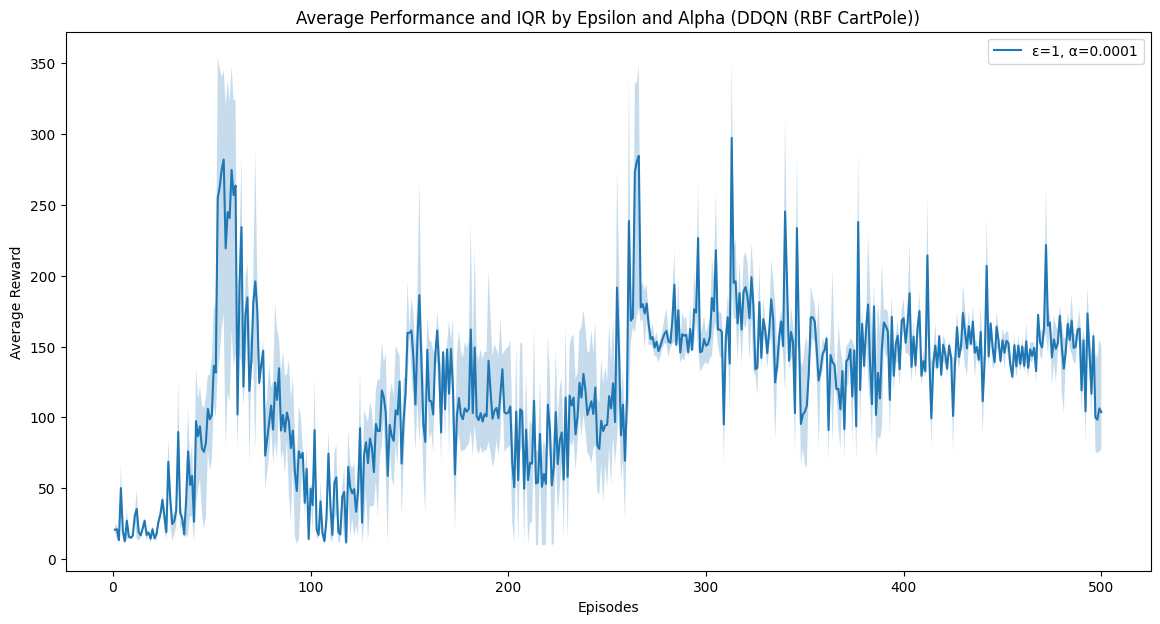

In [62]:
plot_rewards(rewards_data, algorithm_name="DDQN (RBF CartPole)")

In [65]:
# alpha = 1e-4, decaying epsilon = 1, rbf = 4 (save in example_data.pkl)
rewards_data_v2 = main(
    used_alpha=[1e-3],
    used_epsilon=[0.5],  # decaying epsilon
    env=env,
    discretizer=discretizer,
    target_update_delay=5,
    test_delay=10,
    memory_len=10000,
    num_runs=1,
    num_episode=100,
    save_file="" # example_data_v2.pkl
)

Training with epsilon: 0.5, alpha: 0.001
Run 1/1
Episode 1: score: 11.0 - reward: 9.571701097488402
Episode 2: score: 12.0 - reward: 10.654725128412245
Episode 3: score: 11.0 - reward: 9.367536023259163
Episode 4: score: 22.0 - reward: 19.97789677456021
Episode 5: score: 12.0 - reward: 10.347213709726928
Episode 6: score: 9.0 - reward: 7.537019911408425
Episode 7: score: 13.0 - reward: 11.736959148384631
Episode 8: score: 10.0 - reward: 8.855504032224417
Episode 9: score: 9.0 - reward: 7.837648335099221
Episode 10: score: 11.0 - reward: 10.0031817689538
Test Episode 10: test score: 10.0 - test reward: 8.677906708419323
New best test reward. Saving model
Episode 11: score: 13.0 - reward: 11.292950468510389
Episode 12: score: 12.0 - reward: 10.686279250681398
Episode 13: score: 21.0 - reward: 18.956704670190813
Episode 14: score: 22.0 - reward: 20.588931189849973
Episode 15: score: 20.0 - reward: 18.043599517643454
Episode 16: score: 23.0 - reward: 20.48769800812006
Episode 17: score: 17

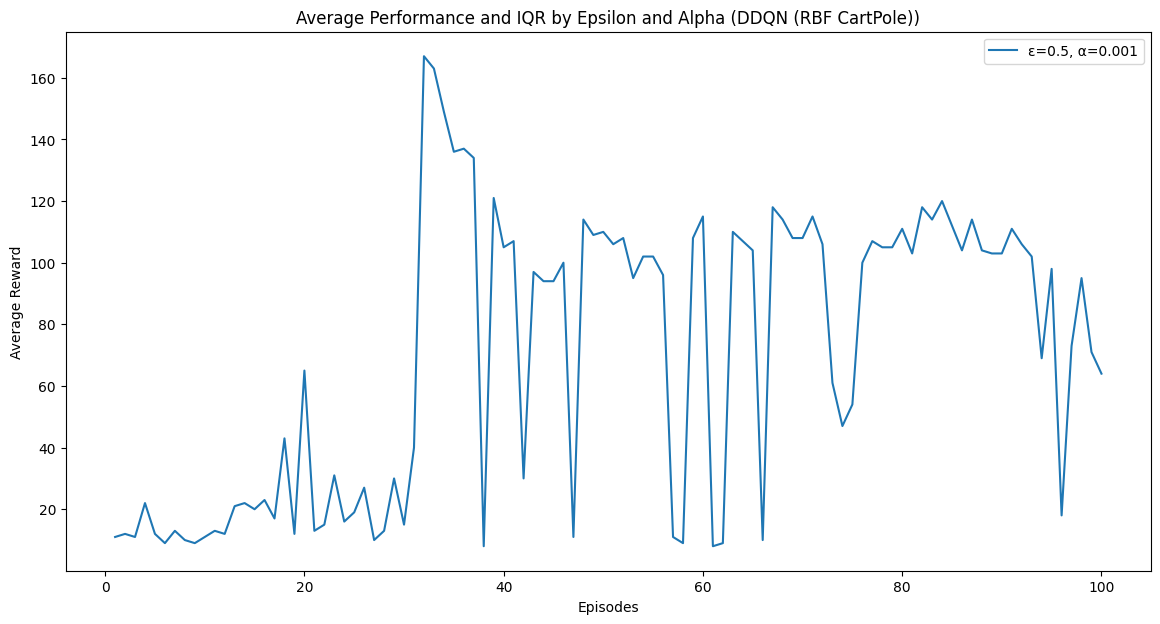

In [66]:
plot_rewards(rewards_data_v2, algorithm_name="DDQN (RBF CartPole)")

In [78]:
# alpha = 1e-3, decaying epsilon = 1, rbf = 4 (save in example_data.pkl)
rewards_data_v3 = main(
    used_alpha=[1e-3],
    used_epsilon=[1],  # decaying epsilon
    env=env,
    discretizer=discretizer,
    target_update_delay=5,
    test_delay=10,
    memory_len=10000,
    num_runs=4,
    num_episode=200,
    save_file="example_data_v2.pkl" # example_data_v2.pkl
)

Training with epsilon: 1, alpha: 0.001
Run 1/4
Episode 1: score: 23.0 - reward: 21.22392731234431
Episode 2: score: 33.0 - reward: 29.515054234117265
Episode 3: score: 9.0 - reward: 7.536277151107789
Episode 4: score: 20.0 - reward: 18.446042475849392
Episode 5: score: 17.0 - reward: 14.805758598446847
Episode 6: score: 23.0 - reward: 21.233086912706497
Episode 7: score: 32.0 - reward: 29.044302749633793
Episode 8: score: 21.0 - reward: 18.282910142838954
Episode 9: score: 31.0 - reward: 26.562629860639568
Episode 10: score: 14.0 - reward: 12.344689664244651
Test Episode 10: test score: 9.0 - test reward: 7.738254648447037
New best test reward. Saving model
Episode 11: score: 13.0 - reward: 11.492252089083195
Episode 12: score: 17.0 - reward: 15.058092560060322
Episode 13: score: 33.0 - reward: 28.291406023502354
Episode 14: score: 15.0 - reward: 13.214644838124514
Episode 15: score: 20.0 - reward: 16.968143201991914
Episode 16: score: 15.0 - reward: 13.453956158459187
Episode 17: scor

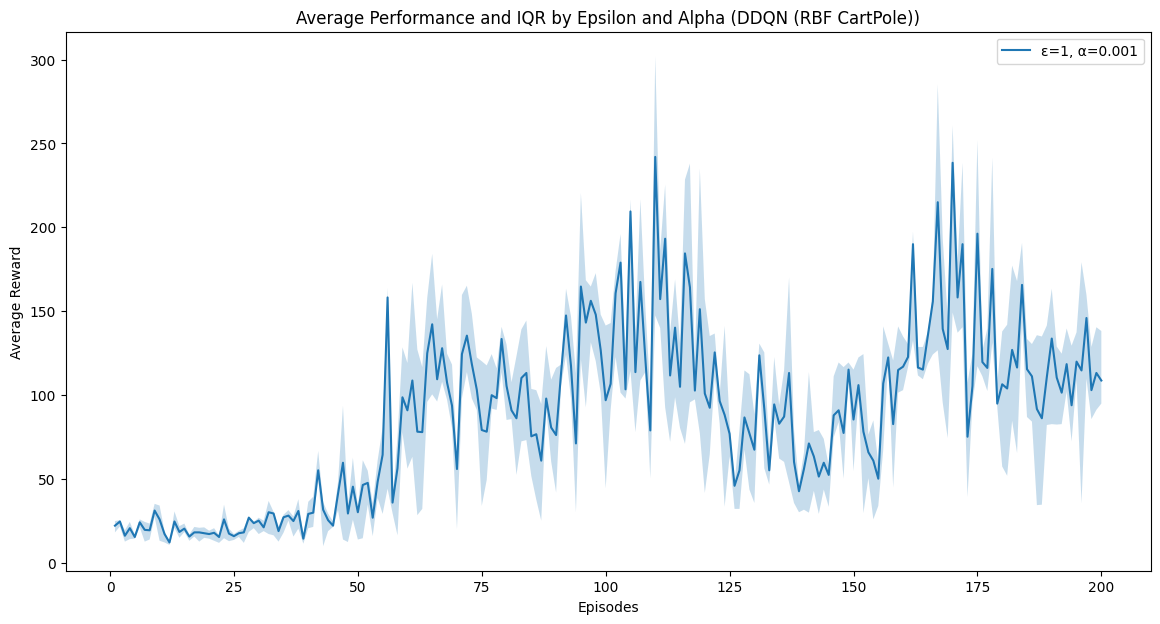

In [80]:
plot_rewards(rewards_data_v3, algorithm_name="DDQN (RBF CartPole)")

In [81]:
# alpha = 1e-3, decaying epsilon = 1, rbf = 4 (save in example_data.pkl)
rewards_data_v3 = main(
    used_alpha=[5e-5],
    used_epsilon=[0.7],  # decaying epsilon
    env=env,
    discretizer=discretizer,
    target_update_delay=5,
    test_delay=10,
    memory_len=10000,
    num_runs=4,
    num_episode=200,
    save_file="example_data_v3.pkl" # example_data_v2.pkl
)

Training with epsilon: 0.7, alpha: 5e-05
Run 1/4
Episode 1: score: 11.0 - reward: 9.481091794371604
Episode 2: score: 19.0 - reward: 16.16656546741724
Episode 3: score: 13.0 - reward: 11.070942249894141
Episode 4: score: 61.0 - reward: 53.95861998796463
Episode 5: score: 28.0 - reward: 25.10251254886388
Episode 6: score: 10.0 - reward: 8.62889800965786
Episode 7: score: 9.0 - reward: 7.70541281402111
Episode 8: score: 15.0 - reward: 13.157499499619009
Episode 9: score: 111.0 - reward: 90.12852344885465
Episode 10: score: 56.0 - reward: 48.51511744856834
Test Episode 10: test score: 8.0 - test reward: 6.788146954774857
New best test reward. Saving model
Episode 11: score: 41.0 - reward: 35.566717082262045
Episode 12: score: 16.0 - reward: 13.952478420734405
Episode 13: score: 135.0 - reward: 98.80356617569927
Episode 14: score: 26.0 - reward: 22.99476208686829
Episode 15: score: 35.0 - reward: 30.811516126990323
Episode 16: score: 161.0 - reward: 125.05830003023146
Episode 17: score: 12

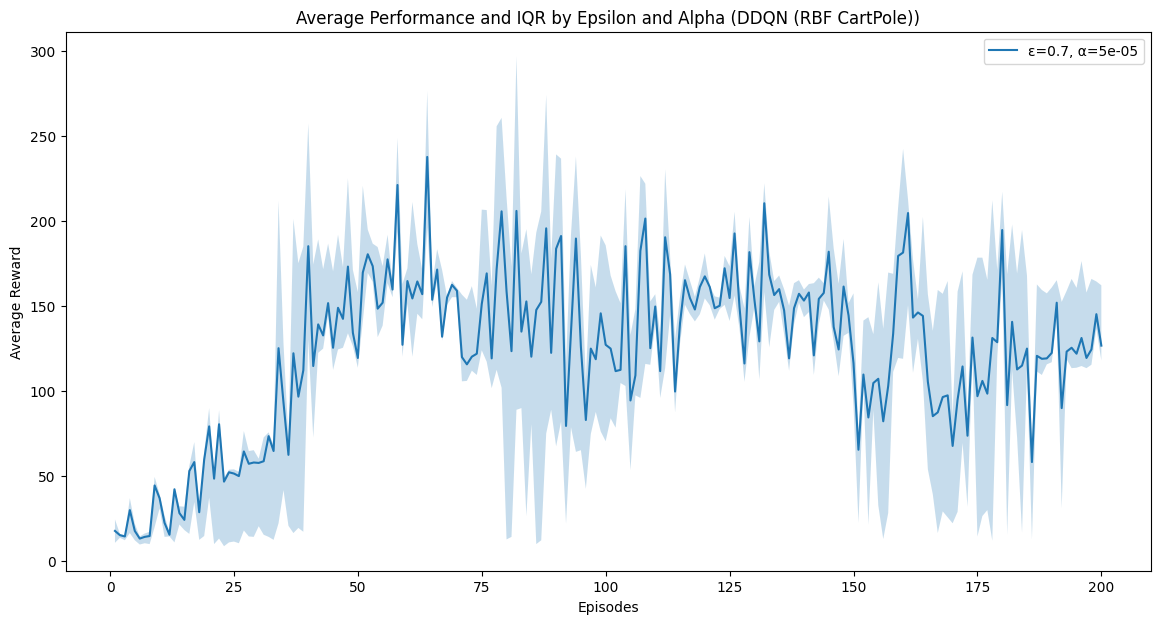

In [82]:
plot_rewards(rewards_data_v3, algorithm_name="DDQN (RBF CartPole)")

In [83]:
# alpha = 1e-3, decaying epsilon = 1, rbf = 4 (save in example_data.pkl)
rewards_data_v4 = main(
    used_alpha=[5e-5],
    used_epsilon=[0.1],  # decaying epsilon
    env=env,
    discretizer=discretizer,
    target_update_delay=5,
    test_delay=10,
    memory_len=10000,
    num_runs=4,
    num_episode=200,
    save_file="example_data_v4.pkl" # example_data_v2.pkl
)

Training with epsilon: 0.1, alpha: 5e-05
Run 1/4
Episode 1: score: 10.0 - reward: 8.826611500978471
Episode 2: score: 9.0 - reward: 7.778886097669602
Episode 3: score: 11.0 - reward: 9.649486984312535
Episode 4: score: 11.0 - reward: 9.818948030471802
Episode 5: score: 10.0 - reward: 8.816591832041741
Episode 6: score: 9.0 - reward: 7.637377831339837
Episode 7: score: 10.0 - reward: 8.64932726547122
Episode 8: score: 9.0 - reward: 7.81112929880619
Episode 9: score: 11.0 - reward: 9.82069643586874
Episode 10: score: 9.0 - reward: 7.7396892517805105
Test Episode 10: test score: 10.0 - test reward: 8.766997151076794
New best test reward. Saving model
Episode 11: score: 10.0 - reward: 8.81805819272995
Episode 12: score: 11.0 - reward: 9.37194295525551
Episode 13: score: 9.0 - reward: 7.625613951683046
Episode 14: score: 11.0 - reward: 9.48806150108576
Episode 15: score: 10.0 - reward: 8.716510450839996
Episode 16: score: 9.0 - reward: 7.672034841775894
Episode 17: score: 10.0 - reward: 8.8

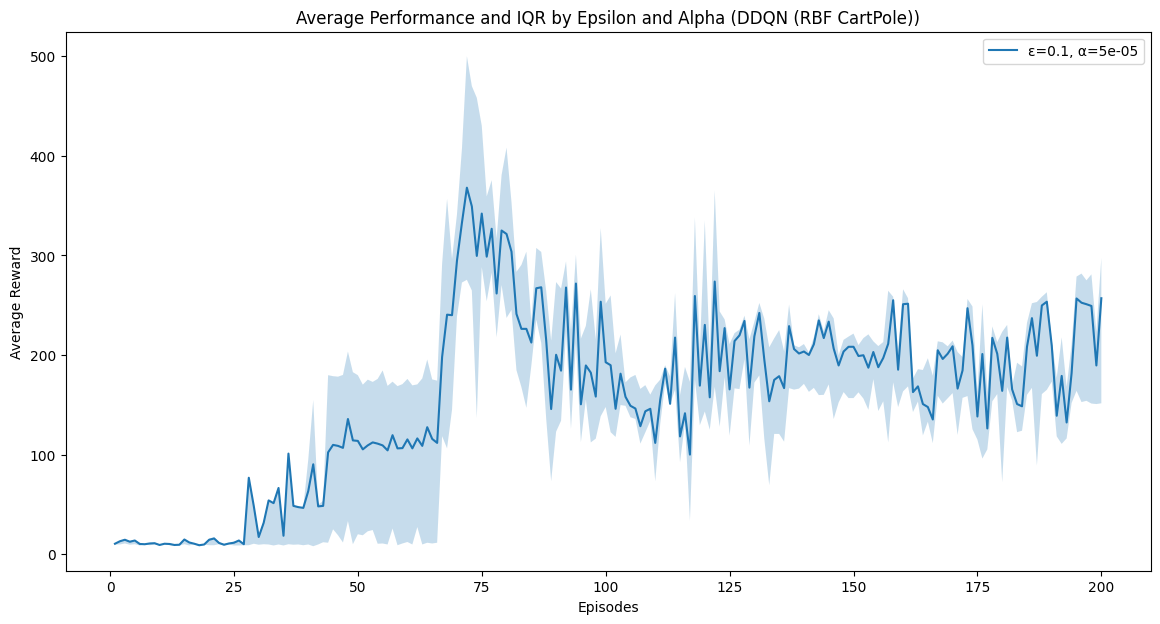

In [84]:
plot_rewards(rewards_data_v4, algorithm_name="DDQN (RBF CartPole)")

# Combine the Results

In [100]:
import pickle

def trim_rewards_and_save(input_file, output_file, episodes=200):
    # Load the original pickle file
    with open(input_file, 'rb') as file:
        rewards_data = pickle.load(file)

    # Trim each rewards list to the first 'episodes' entries
    for epsilon, alphas in rewards_data.items():
        for alpha, rewards_lists in alphas.items():
            trimmed_rewards_lists = [rewards_list[:episodes] for rewards_list in rewards_lists]
            rewards_data[epsilon][alpha] = trimmed_rewards_lists

    # Save the modified data to a new pickle file
    with open(output_file, 'wb') as file:
        pickle.dump(rewards_data, file)

    print(f"Modified data saved to {output_file}")

# Example usage
input_file = 'DDQN_RBF_CP_1e-4_1.pkl'
output_file = 'DDQN_RBF_CP_1e-4_1_trimmed.pkl'
trim_rewards_and_save(input_file, output_file)

Modified data saved to DDQN_RBF_CP_1e-4_1_trimmed.pkl


In [104]:
def combine_pickles_with_unique_alphas(pickle_files, output_file):
    combined_data = {}

    for pickle_file in pickle_files:
        with open(pickle_file, 'rb') as file:
            data = pickle.load(file)

            # Iterate over epsilon keys
            for epsilon, alphas in data.items():
                if epsilon not in combined_data:
                    combined_data[epsilon] = {}

                # Iterate over alpha keys
                for alpha, rewards in alphas.items():
                    if alpha not in combined_data[epsilon]:
                        # If this alpha is new for this epsilon, add it directly
                        combined_data[epsilon][alpha] = rewards
                    else:
                        # If this alpha already exists, extend the existing rewards list
                        combined_data[epsilon][alpha].extend(rewards)

    # Save combined data to a new pickle file
    with open(output_file, 'wb') as file:
        pickle.dump(combined_data, file)

    print(f"Combined pickle data saved to {output_file}")


# Example usage:
pickle_files = ['DDQN_RBF_CP_1e-3_1.pkl',
                'DDQN_RBF_CP_1e-4_1_trimmed.pkl',
                'DDQN_RBF_CP_5e-5_0pt1.pkl',
                'DDQN_RBF_CP_5e-5_0pt7.pkl'
                ]

combine_pickles_with_unique_alphas(pickle_files, 'DDQN_RBF_CP_combined.pkl')

Combined pickle data saved to DDQN_RBF_CP_combined.pkl


In [105]:
rewards_data = load_rewards_data('DDQN_RBF_CP_combined.pkl')

Rewards data loaded from DDQN_RBF_CP_combined.pkl


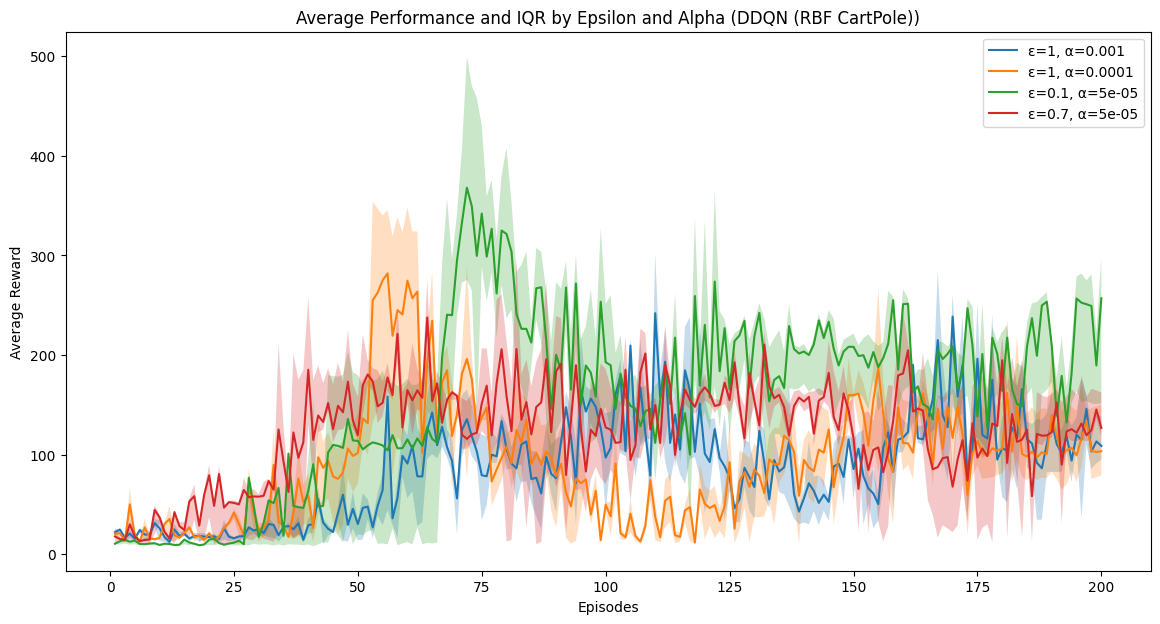

In [106]:
plot_rewards(rewards_data, algorithm_name="DDQN (RBF CartPole)")